In [1]:
#COMET ML API KEY YarDlAXZLHepLKBFlSPyWbDPt
'''import comet_ml
comet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")
from comet_ml import Experiment
experiment = Experiment(
    api_key="YarDlAXZLHepLKBFlSPyWbDPt",
    project_name="asd-pytorch-atp-c",
    workspace="mattbeze",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)
hyper_params = {
    "input_size": 298,
    "hidden_size1": 100,
    "hidden_size2": 15,
    "num_layers": 4,
    "num_classes": 2,
    "batch_size": 35,
    "num_epochs": 50,
    "learning_rate": 0.01
}
experiment.log_parameters(hyper_params)'''


'import comet_ml\ncomet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")\nfrom comet_ml import Experiment\nexperiment = Experiment(\n    api_key="YarDlAXZLHepLKBFlSPyWbDPt",\n    project_name="asd-pytorch-atp-c",\n    workspace="mattbeze",\n    auto_metric_logging=True,\n    auto_param_logging=True,\n    auto_histogram_weight_logging=True,\n    auto_histogram_gradient_logging=True,\n    auto_histogram_activation_logging=True,\n)\nhyper_params = {\n    "input_size": 298,\n    "hidden_size1": 100,\n    "hidden_size2": 15,\n    "num_layers": 4,\n    "num_classes": 2,\n    "batch_size": 35,\n    "num_epochs": 50,\n    "learning_rate": 0.01\n}\nexperiment.log_parameters(hyper_params)'

In [2]:
import seaborn as sn
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [3]:
Training_Data = pd.ExcelFile("Labels.xlsx") #Training Data already pre-scaled to the IBIS Data set
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Training_Data.parse(Training_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['Case','Visit','MATCH','INDEX','ASD+','ASD-','Gender'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['Final Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['CASE','MATCH','INDEX','ASD+','ASD-'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(325, 298)
(325, 1)


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_features)

scaled_data.shape
labels.shape

X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, labels, test_size=0.1, random_state=seed_value)
sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2)

#Imblearn has other SMOTE variants to look into.
#ADASYN - creates synthetic data according to the data density. 
#The synthetic data generation would inversely proportional to the density of the minority class. It means more synthetic data are created in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.
#In simpler terms, in an area where the minority class is less dense, the synthetic data are created more. Otherwise, the synthetic data is not made so much.

#SMOTENC - Denote which features are categorical, and SMOTE would resample the categorical data instead of creating synthetic data.

#Borderline SMOTE
#K SMOTE

#Should increase testing size. Play with testing/training split.
X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.

for x in X_train_smoted: #Round sex to be categorical
    x[297] = round(x[297]) 

print(X_train_smoted.shape)
print(Y_train_smoted.shape)
print(X_test.shape)

(484, 298)
(484, 1)
(33, 298)


In [5]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 
#Need to figure out how to get dropout
D_in, H1, H2, D_out = 298, 100, 15, 1
EPOCHS = 85
BATCH_SIZE = 35
LEARNING_RATE = 0.01

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(X_train_smoted), 
                       torch.FloatTensor(Y_train_smoted.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(X_test))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=33) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [6]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.15)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [7]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=298, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)


In [8]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [9]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=33)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(Y_test.values))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(Y_test.values), y_pred_list)
    ppv = precision_score(Y_test, y_pred_list, average=None)
    recall = recall_score(Y_test, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.49497 | Acc: 48.643
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.34940 | Acc: 50.143
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.32733 | Acc: 50.071
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.31724 | Acc: 49.786
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 005: | Loss: 1.23526 | Acc: 49.857
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.13916 | Acc: 50.214
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.04209 | Acc: 54.786
Validation Accuracy |  18.181818181818183  PPV |  [1.  0.1]  Recall |  [0.1 1. ]
Training Epoch 008: | Loss: 0.89981 | Acc: 63.857
Validation Accuracy |  51.515151515151516  PPV |  [1.         0.15789474]  Recall |  [0.46666667 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 009: | Loss: 0.87723 | Acc: 71.357
Validation Accuracy |  18.181818181818183  PPV |  [1.  0.1]  Recall |  [0.1 1. ]
Training Epoch 010: | Loss: 0.85223 | Acc: 70.286
Validation Accuracy |  36.36363636363637  PPV |  [0.90909091 0.09090909]  Recall |  [0.33333333 0.66666667]
Training Epoch 011: | Loss: 0.66134 | Acc: 77.714
Validation Accuracy |  69.6969696969697  PPV |  [0.95454545 0.18181818]  Recall |  [0.7        0.66666667]
Training Epoch 012: | Loss: 0.75087 | Acc: 75.929
Validation Accuracy |  87.87878787878788  PPV |  [0.96428571 0.4       ]  Recall |  [0.9        0.66666667]
Training Epoch 013: | Loss: 0.71665 | Acc: 77.000
Validation Accuracy |  72.72727272727273  PPV |  [0.95652174 0.2       ]  Recall |  [0.73333333 0.66666667]
Training Epoch 014: | Loss: 0.62917 | Acc: 80.929
Validation Accuracy |  33.33333333333333  PPV |  [1.   0.12]  Recall |  [0.26666667 1.        ]
Training Epoch 015: | Loss: 0.63405 | Acc: 81.143
Validation Accuracy |  33.33333333333333  

Validation Accuracy |  81.81818181818183  PPV |  [0.96153846 0.28571429]  Recall |  [0.83333333 0.66666667]
Training Epoch 063: | Loss: 0.24860 | Acc: 96.000
Validation Accuracy |  87.87878787878788  PPV |  [0.96428571 0.4       ]  Recall |  [0.9        0.66666667]
Training Epoch 064: | Loss: 0.30179 | Acc: 95.500
Validation Accuracy |  69.6969696969697  PPV |  [0.95454545 0.18181818]  Recall |  [0.7        0.66666667]
Training Epoch 065: | Loss: 0.34705 | Acc: 94.929
Validation Accuracy |  81.81818181818183  PPV |  [0.96153846 0.28571429]  Recall |  [0.83333333 0.66666667]
Training Epoch 066: | Loss: 0.45954 | Acc: 90.786
Validation Accuracy |  84.84848484848484  PPV |  [0.96296296 0.33333333]  Recall |  [0.86666667 0.66666667]
Training Epoch 067: | Loss: 0.59716 | Acc: 90.357
Validation Accuracy |  78.78787878787878  PPV |  [0.96 0.25]  Recall |  [0.8        0.66666667]
Training Epoch 068: | Loss: 0.41745 | Acc: 95.786
Validation Accuracy |  57.57575757575758  PPV |  [0.94444444 0.13

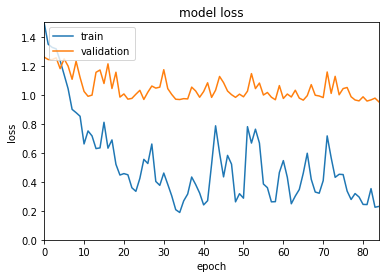

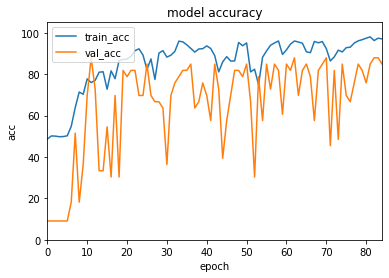

In [10]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  84.84848484848484  PPV |  [0.96296296 0.33333333]  Recall |  [0.86666667 0.66666667]


<AxesSubplot:>

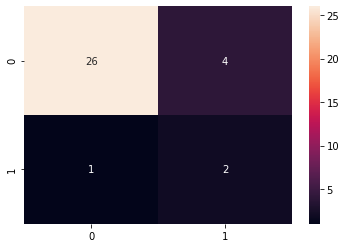

In [11]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(Y_test, y_pred_list)
ppv = precision_score(Y_test, y_pred_list, average=None)
recall = recall_score(Y_test, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(Y_test, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

In [12]:
print(classification_report(Y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91        30
         1.0       0.33      0.67      0.44         3

    accuracy                           0.85        33
   macro avg       0.65      0.77      0.68        33
weighted avg       0.91      0.85      0.87        33



In [13]:
#Save model once everything is all figured out

#Models below were initially trained at 150 epochs. Re-trained for optimizing ppv, recall, and acc, without overtraining.
'''
10% Test - 27 03 ppv - 0.25 recall - 0.3333
            2  1
15% Test - 33 10 ppv - 0.09 recall - 0.17
            5  1
20% Test - 45 13 ppv - 0.07 recall - 0.14
            6  1 
25% Test - 54 19 ppv - 0.17 recall - 0.4444
            5  4
30% Test - 47 40 ppv - 0.11 recall - 0.45
            6  5
35% Test - 81 21 ppv - 0.125 recall - 0.25
            9  3
'''

'\n10% Test - 27 03 ppv - 0.25 recall - 0.3333\n            2  1\n15% Test - 33 10 ppv - 0.09 recall - 0.17\n            5  1\n20% Test - 45 13 ppv - 0.07 recall - 0.14\n            6  1 \n25% Test - 54 19 ppv - 0.17 recall - 0.4444\n            5  4\n30% Test - 47 40 ppv - 0.11 recall - 0.45\n            6  5\n35% Test - 81 21 ppv - 0.125 recall - 0.25\n            9  3\n'